## Importing Libraries

In [3]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

# Visualization
import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Reading the data

In [4]:
# Get the data
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"

files = glob.glob( folder + "Ex *.xlsx" ) 

dfs = []
min = []
k = 0
for file in files:
    k = k +1
    if k > 2:
        break
    df = pd.read_excel(file) # reading the excel file
    
    mice_min = df.iloc[:,0] #getting only the minutes
    mice_temp = df.iloc[:,3::2] # slicing the data for only temperature
    
    min.append(mice_min) # adding minutes into the list
    dfs.append(mice_temp) # adding the file into the list
  
     

## SVM for each dataset

Prediction for CC006-315 EXP 2 MRSA CC Deg. C Data is: 
 [-1 -1 -1 ... -1 -1 -1] 
 with score 
  [5.00344009e+02 5.10225890e+02 5.10816323e+02 ... 1.66227586e-01
 1.56338429e-01 1.51763302e-01]
Prediction for CC006-316 EXP 2 MRSA CC Deg. C Data is: 
 [-1 -1  1 ... -1 -1 -1] 
 with score 
  [603.25284544 614.10833085 634.25157323 ... 225.21546893 232.75911575
 228.33650437]
Prediction for CC006-317 EXP 2 MRSA CC Deg. C Data is: 
 [-1 -1 -1 ... -1 -1 -1] 
 with score 
  [558.08559347 514.52503289 517.56922595 ... 232.8390476  243.36631565
 241.8091004 ]
Prediction for CC019-1392 EXP 2 MRSA CC Deg. C Data is: 
 [1 1 1 ... 1 1 1] 
 with score 
  [627.66809657 629.46176212 619.05766516 ... 639.08455498 607.13794183
 596.17003008]
Prediction for CC019-1393 EXP 2 MRSA CC Deg. C Data is: 
 [ 1  1  1 ... -1 -1 -1] 
 with score 
  [5.76011380e+02 5.74815128e+02 5.89429434e+02 ... 6.42702958e-07
 2.08388087e-07 1.09271014e-07]
Prediction for CC043-455 EXP 2 MRSA CC Deg. C Data is: 
 [1 1 1 ... 1 

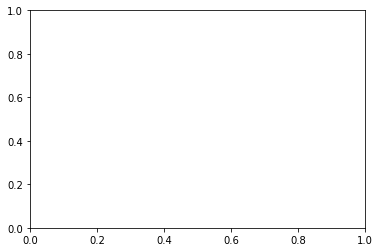

In [20]:
fig,ax = plt.subplots()
fig.set_facecolor("white") # Changing the border to white

model = svm.OneClassSVM() # importing the model

# Plotting each file's temperature vs. minutes
for i in range(len(min)):
    mice_min = min[i] # renaming the minutes to the current column
    mice_temp = dfs[i] # renaming the temperature to the current column
    x_axis = mice_min # defining the x axis
    
    # A for loop for the temperatures (extracting only the column of data frame)
    for j in range(mice_temp.shape[1]): 
        ax.cla() # clear axis for each individual mouse
        y_axis = mice_temp.iloc[:,j] # defining the y axis
        names = mice_temp.columns[j] # extracting the names of the columns (mouse name)
        mask = y_axis.notna() # will keep the true values
        x1 = x_axis[mask]
        y1 = y_axis[mask]
        #Time Delay Embedding
        Y = tde.tde(y1)
        Y=Y.T #transporting the data
        Y
        #fit the data
        model.fit(Y[:5000,:])
        #predict the data
        predict = model.predict(Y[5001:,:])
        #plotting the scatterplot
        #ax.scatter(Y[5001:,0],Y[5001:,1], c = predict)
        scores = model.score_samples(Y[5001:,:])
        print("Prediction for " + names, "is: \n", predict, "\n with score \n ", +  scores)
    